In [2]:

import sys
sys.path.append('..//')

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

from parsmooth._base import MVNStandard, ConditionalMomentsModel, MVNSqrt
from parsmooth.linearization import cubature, extended
from parsmooth.methods import iterated_smoothing

from tests._pssm import make_parameters
from tests._pssm import get_data as population_data

In [3]:
seed = 40
np.random.seed(seed)

T = 1 + 2**7
lam = 10.
Q = jnp.array([[0.3**2]])
dt = 1.
m0 = jnp.array([jnp.log(7.)])

true_states, observations = population_data(m0, dt, T, Q, lam, seed)


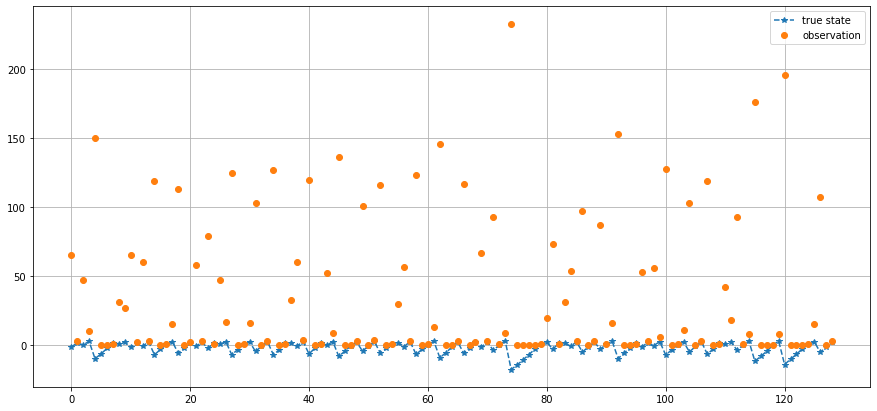

In [4]:
plt.figure(figsize=(15,7))
plt.plot(true_states, "*--", label = "true state")
plt.plot(observations, "o", label = "observation")
plt.legend()
plt.grid()
plt.show()


# make parameters


In [5]:
dim_x = 1
mean_f, cov_f, mean_h, cov_h, chol_f, chol_h = make_parameters(lam, seed, Q)



In [6]:
sqrt_transition_model = ConditionalMomentsModel(mean_f, chol_f)
sqrt_observation_model = ConditionalMomentsModel(mean_h, chol_h)

transition_model = ConditionalMomentsModel(mean_f, cov_f)
observation_model = ConditionalMomentsModel(mean_h, cov_h)

# m0 = np.random.randn(dim_x)
chol_x0 = np.random.randn(dim_x,dim_x)
cov_x0 = chol_x0 @ chol_x0.T

x0 = MVNStandard(m0, cov_x0) # initial guess
x0_sqrt = MVNSqrt(m0, chol_x0) # sqrt initial guess

m_nominal = np.random.randn(T + 1, dim_x)
P_nominal = np.repeat(np.eye(dim_x, dim_x)[None, ...], T + 1, axis=0)
cholP_nominal = P_nominal
x_nominal_sqrt = MVNSqrt(m_nominal, cholP_nominal) # initial nominal trajectory
x_nominal = MVNStandard(m_nominal, P_nominal)      # sqrt initial nominal trajectory


# Iterated result - Extended

In [7]:
iteration = 20

In [8]:
extended_std_seq = iterated_smoothing(observations, x0, transition_model, observation_model,
                                      extended, x_nominal, False,
                                      criterion=lambda i, *_: i < iteration)




In [9]:
extended_sqrt_seq = iterated_smoothing(observations, x0_sqrt, sqrt_transition_model,
                                       sqrt_observation_model, extended, x_nominal_sqrt,
                                       False, criterion=lambda i, *_: i < iteration)




In [10]:

extended_std_par = iterated_smoothing(observations, x0, transition_model, observation_model,
                                      extended, x_nominal, True,
                                      criterion=lambda i, *_: i < iteration)


In [11]:
extended_sqrt_par = iterated_smoothing(observations, x0_sqrt, sqrt_transition_model,
                                       sqrt_observation_model, extended, x_nominal_sqrt, True,
                                       criterion=lambda i, *_: i < iteration)




In [12]:
np.testing.assert_array_almost_equal(extended_sqrt_seq.mean,
                                     extended_sqrt_par.mean, decimal=7)




AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 4 / 130 (3.08%)
Max absolute difference: 3.25583385e-07
Max relative difference: 5.00358887e-06
 x: array([[ 1.1042567e+00],
       [ 1.9889942e+00],
       [-1.6506454e+00],...
 y: array([[ 1.1042567e+00],
       [ 1.9889942e+00],
       [-1.6506454e+00],...

In [ ]:
np.testing.assert_array_almost_equal(extended_std_seq.mean,
                                     extended_std_par.mean, decimal=3)


# Iterated result - Cubature


In [ ]:
cubature_std_seq = iterated_smoothing(observations, x0, transition_model, observation_model,
                                      cubature, x_nominal, False,
                                      criterion=lambda i, *_: i < iteration)



In [ ]:
cubature_sqrt_seq = iterated_smoothing(observations, x0_sqrt, sqrt_transition_model,
                                       sqrt_observation_model, cubature, x_nominal_sqrt,
                                       False, criterion=lambda i, *_: i < iteration)




In [ ]:

cubature_std_par = iterated_smoothing(observations, x0, transition_model, observation_model,
                                      cubature, x_nominal, True,
                                      criterion=lambda i, *_: i < iteration)

In [ ]:

cubature_sqrt_par = iterated_smoothing(observations, x0_sqrt, sqrt_transition_model,
                                       sqrt_observation_model, cubature, x_nominal_sqrt, True,
                                       criterion=lambda i, *_: i < iteration)



In [ ]:

np.testing.assert_array_almost_equal(cubature_sqrt_seq.mean,
                                     cubature_sqrt_par.mean, decimal=8)

In [ ]:

np.testing.assert_array_almost_equal(cubature_sqrt_seq.mean,
                                     cubature_sqrt_par.mean, decimal=8)

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(extended_std_seq.mean,"o--", label = "iterated-par state")
plt.plot(true_states, "*--", label = "true state")

plt.grid()
plt.legend()
plt.show()

